In [2]:
import numpy as np    
import pandas as pd     
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [4]:
cd 

C:\Users\JDL


In [5]:
cd Desktop

C:\Users\JDL\Desktop


In [6]:
power= pd.read_csv('2019 태양광 발전 경진대회/Refined Data/please.csv', index_col=0)

In [7]:
power.set_index(power['일시'], inplace=True)
power['일시'] = pd.to_datetime(power['일시'], errors='coerce')
power['시간'] = power['hour']
power['월'] = power['month']
power = power.drop(['일시', 'hour', 'month'], axis=1)

In [8]:
power.columns

Index(['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)',
       '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)',
       '중하층운량(10분위)', '지면온도(°C)', '5cm 지중온도(°C)', '10cm 지중온도(°C)',
       '20cm 지중온도(°C)', '30cm 지중온도(°C)', '1시간평균 미세먼지농도(㎍/㎥)',
       '태양광 전력거래량\n(단위: MWh)', '시간', '월'],
      dtype='object')

## Model Training

In [9]:
split_date = '2019-04-01'

power_train = power.loc[power.index < split_date]
power_test = power.loc[power.index >= split_date]

In [10]:
x_train = power_train.drop('태양광 전력거래량\n(단위: MWh)', axis =1)
x_test = power_test.drop('태양광 전력거래량\n(단위: MWh)', axis =1)
y_train = power_train['태양광 전력거래량\n(단위: MWh)']
y_test = power_test['태양광 전력거래량\n(단위: MWh)']       

In [11]:
xgr_init = xgb.XGBRegressor()
xgr_init.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

C:\Users\JDL\Anaconda3\envs\venv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\JDL\Anaconda3\envs\venv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [12]:
init_pred = xgr_init.predict(x_test)

In [13]:
def nmae(y_true, y_pred):     
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/7.381)) 

In [14]:
print('nMAE:',nmae(y_true=y_test,
                   y_pred=init_pred))

nMAE: 0.034461995926094904


## Model Interpretation

In [15]:
import skater
import eli5
import shap
shap.initjs()

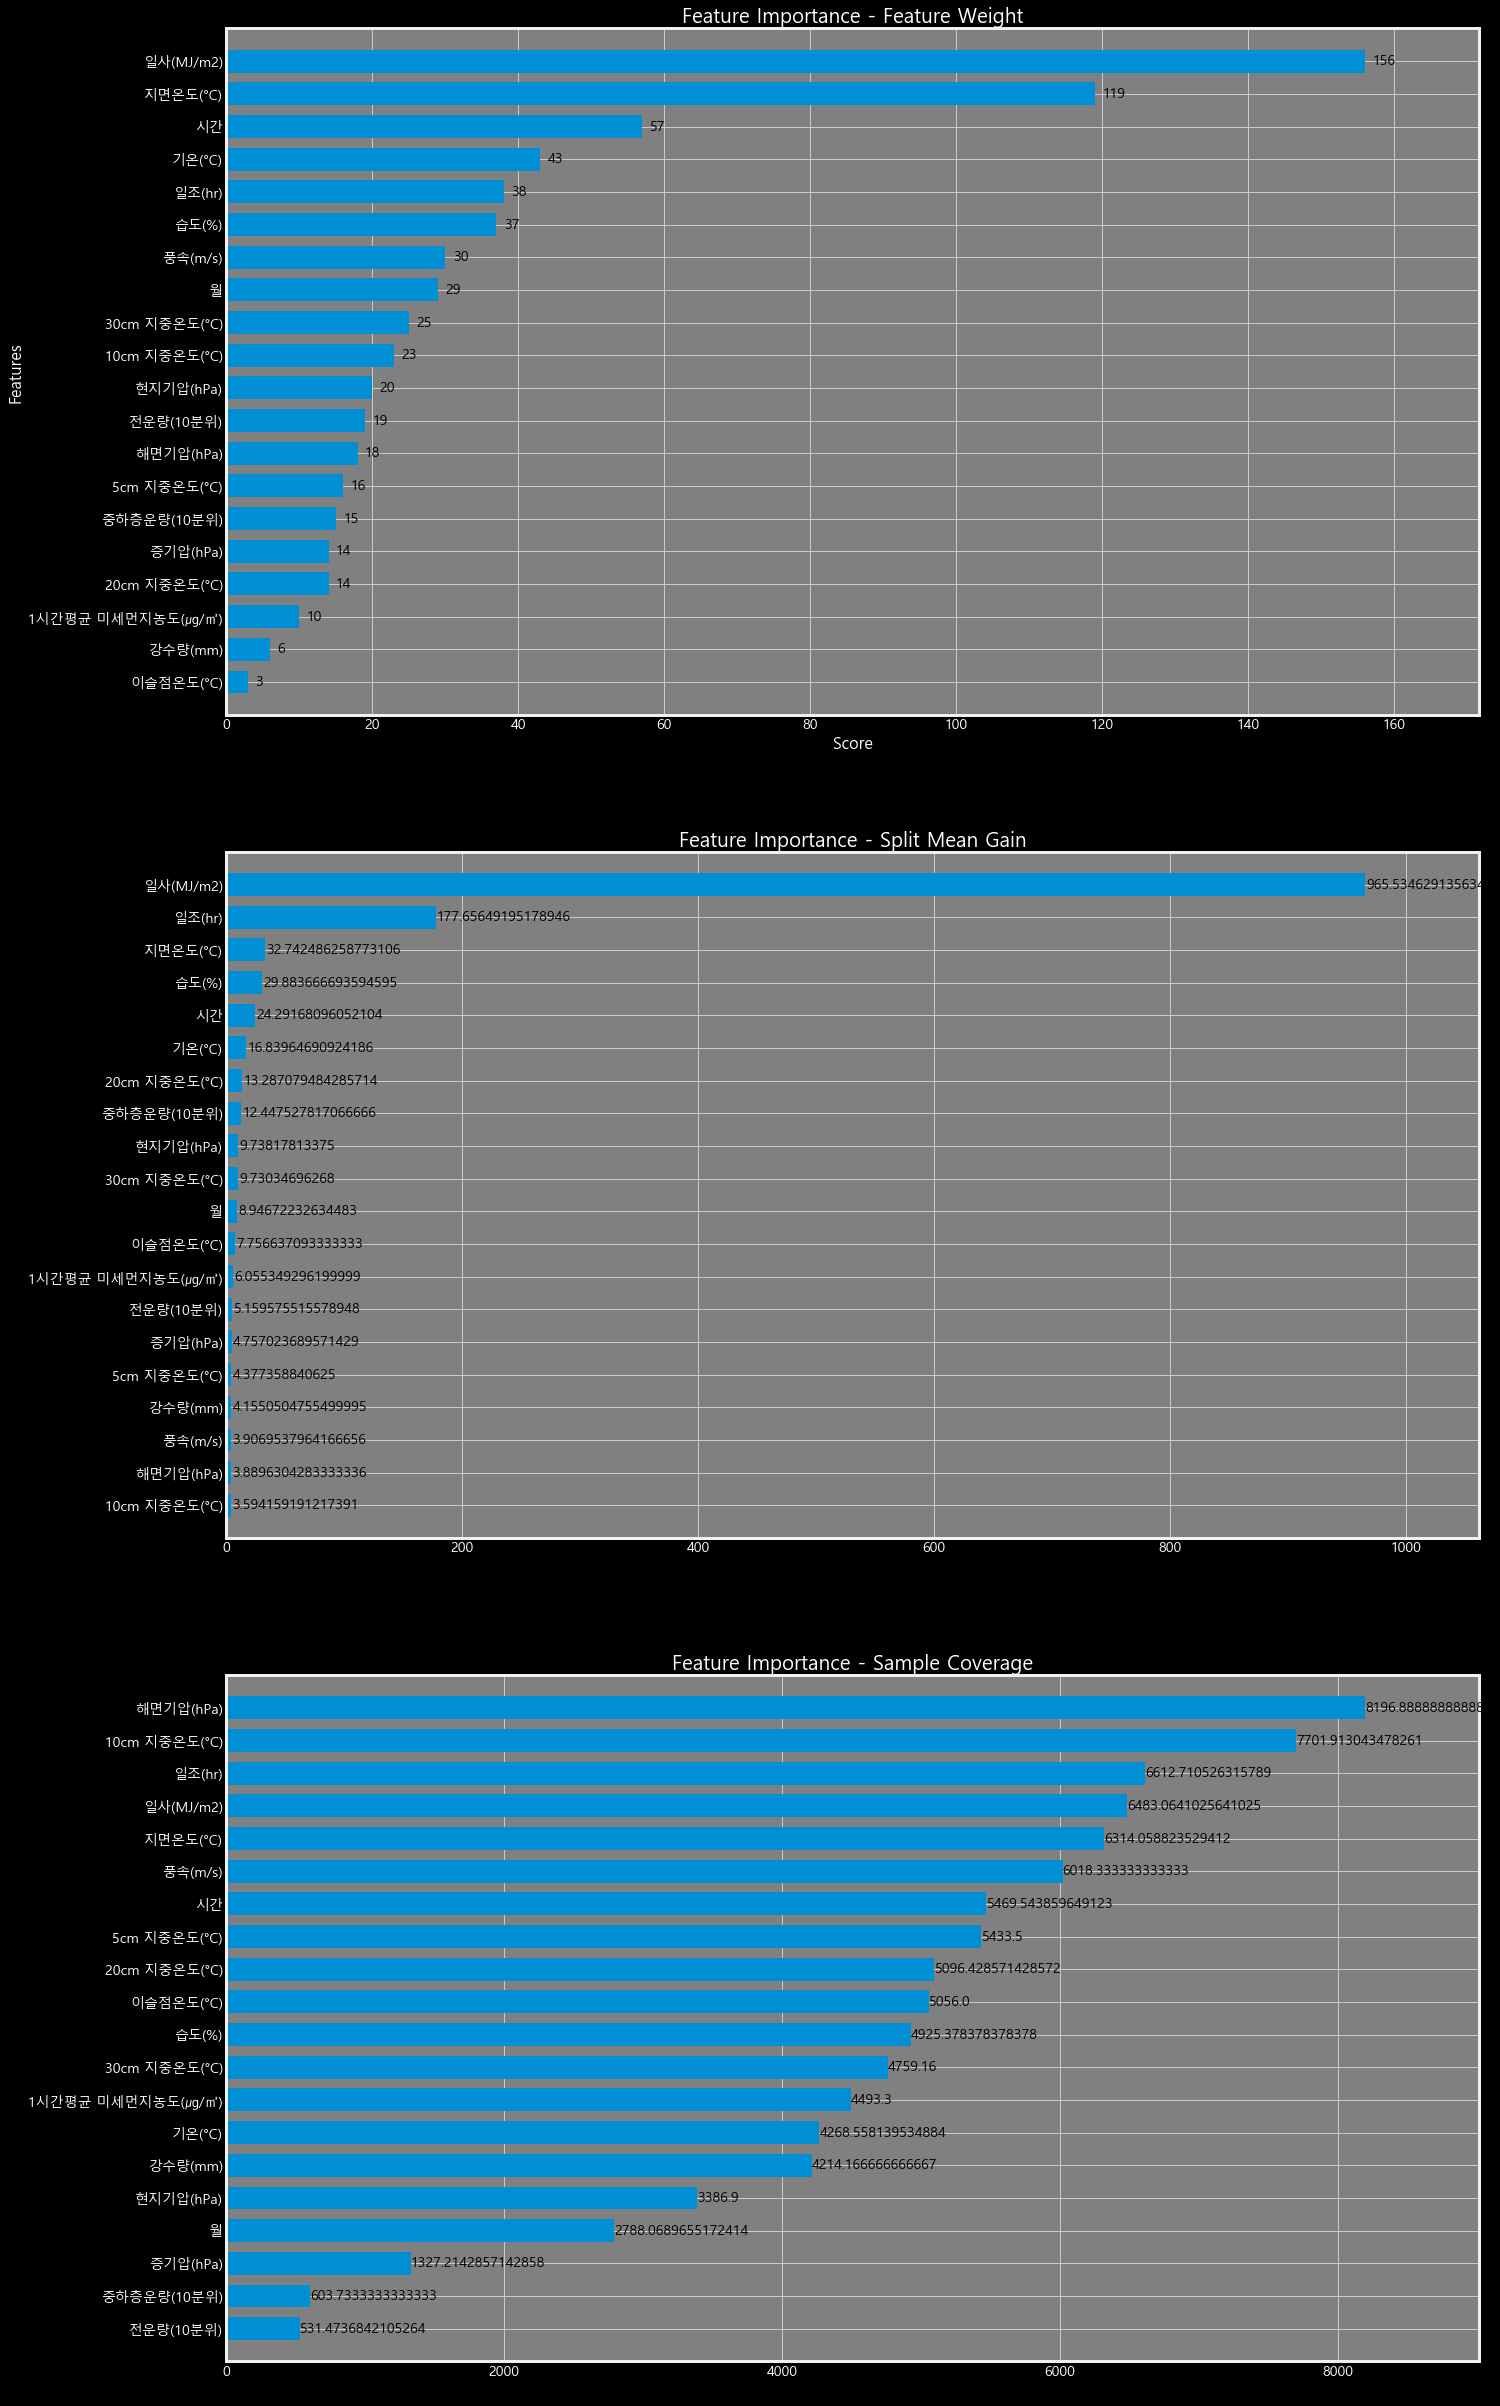

In [16]:
# feature importance plot by XGBoost weight, gain, coverage 
# feature importance rank based on training

fig = plt.figure(figsize = (20, 40))
fig.set_facecolor('k')

ax1 = fig.add_subplot(3,1,1)
ax1.set_facecolor('grey')
ax1.tick_params(axis='x', colors='w')
ax1.tick_params(axis='y', colors='w')
plt.ylabel('features', fontsize = 16, color = 'w')
plt.xlabel('score', fontsize = 16, color='w')
p1 = plot_importance(xgr_init, xlabel='Score', ylabel='Features', importance_type='weight', height = 0.7, ax=ax1)
t1=  ax1.set_title("Feature Importance - Feature Weight", color ='w')

ax2 = fig.add_subplot(3,1,2)
ax2.set_facecolor('grey')
ax2.tick_params(axis='x', colors='w')
ax2.tick_params(axis='y', colors='w')
p2 = plot_importance(xgr_init, xlabel='Score', ylabel='Features', importance_type='gain', height = 0.7, ax=ax2)
t2 = ax2.set_title("Feature Importance - Split Mean Gain", color ='w')

ax3 = fig.add_subplot(3,1,3)
ax3.set_facecolor('grey')
ax3.tick_params(axis='x', colors='w')
ax3.tick_params(axis='y', colors='w')
p3 = plot_importance(xgr_init, xlabel='Score', ylabel='Features', importance_type='cover', height = 0.7, ax=ax3)
t3 = ax3.set_title("Feature Importance - Sample Coverage", color ='w')

## Global Interpretation with Skater

In [17]:
# local interpretation(LIME) of regression is not supported yet on WIndow.
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.util.logger import _INFO, _DEBUG
interpreter = Interpretation(training_data=x_test, training_labels=y_test, 
                             feature_names=list(x_test.columns))

im_model = InMemoryModel(xgr_init.predict, examples=x_test, model_type='regressor', 
                         feature_names=list(x_test.columns), log_level=_INFO)

2019-09-03 11:25:49,336 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[20/20] features ████████████████████ Time elapsed: 15 seconds

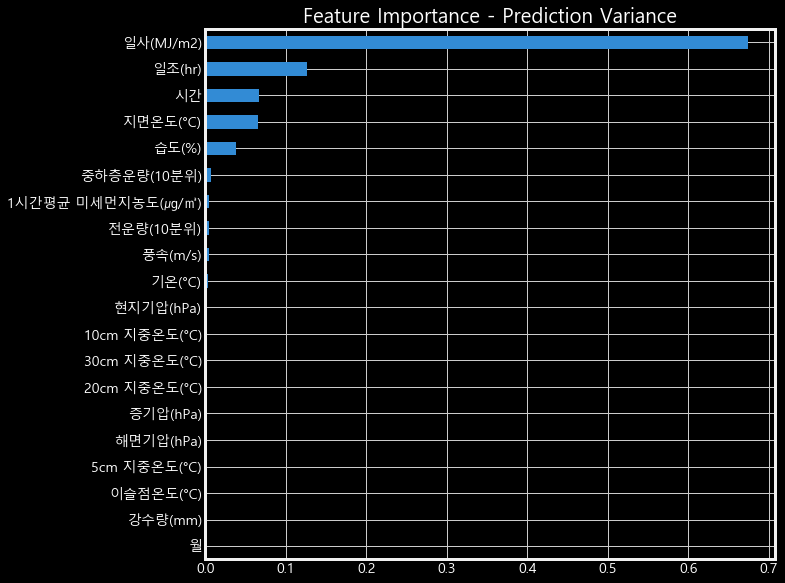

In [18]:
# feature importance plot by prediction variance
fig = plt.figure(figsize = (20, 20))
fig.set_facecolor('k')
ax1 = fig.add_subplot(2,2, 1)
ax1.set_facecolor('k')
ax1.tick_params(axis='x', colors='w')
ax1.tick_params(axis='y', colors='w')
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True,  n_samples=100000, ax=ax1)
t=ax1.set_title("Feature Importance - Prediction Variance", fontsize = 20, color ='w')

In [19]:
x_test.columns

Index(['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)',
       '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)',
       '중하층운량(10분위)', '지면온도(°C)', '5cm 지중온도(°C)', '10cm 지중온도(°C)',
       '20cm 지중온도(°C)', '30cm 지중온도(°C)', '1시간평균 미세먼지농도(㎍/㎥)', '시간', '월'],
      dtype='object')

2019-09-03 11:26:18,736 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[25/25] grid cells ████████████████████ Time elapsed: 23 seconds

2019-09-03 11:26:45,496 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[11/11] grid cells ████████████████████ Time elapsed: 20 seconds

2019-09-03 11:27:07,712 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[50/50] grid cells ████████████████████ Time elapsed: 16 seconds

2019-09-03 11:27:26,178 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[47/47] grid cells ████████████████████ Time elapsed: 15 seconds

[[<Figure size 432x288 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1f24cbdab70>],
 [<Figure size 432x288 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1f24cc8b860>],
 [<Figure size 432x288 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1f24cc8ed68>],
 [<Figure size 432x288 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1f24cd32320>]]

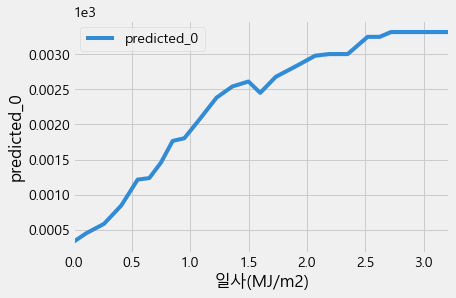

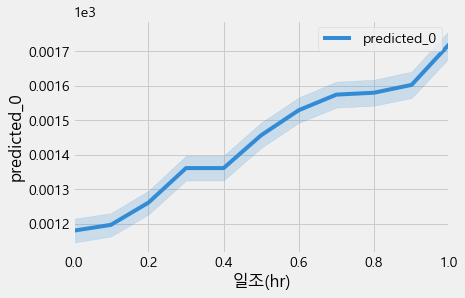

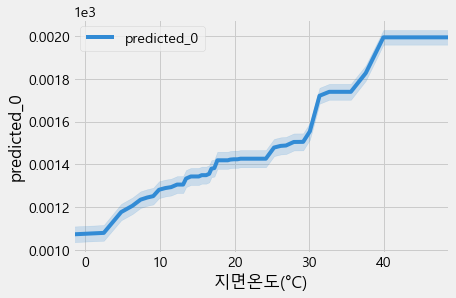

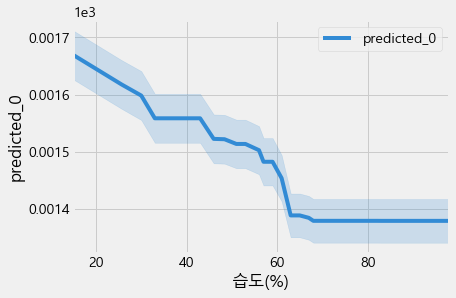

In [20]:
# PDP of high-ranking features
pdp_features = ['일사(MJ/m2)', '일조(hr)',  '지면온도(°C)', '습도(%)']
interpreter.partial_dependence.plot_partial_dependence(pdp_features, im_model, grid_resolution=50, grid_range=(0,1), n_samples=2000, with_variance=True, figsize = (6, 4)) 

2019-09-03 11:27:44,509 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[1/1] grid cells ████████████████████ Time elapsed: 5 seconds

2019-09-03 11:27:50,580 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[50/50] grid cells ████████████████████ Time elapsed: 15 seconds

2019-09-03 11:28:08,080 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[50/50] grid cells ████████████████████ Time elapsed: 16 seconds

[[<Figure size 432x288 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1f24cd9a6a0>],
 [<Figure size 432x288 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1f24dd76b00>],
 [<Figure size 432x288 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1f24ddb5518>]]

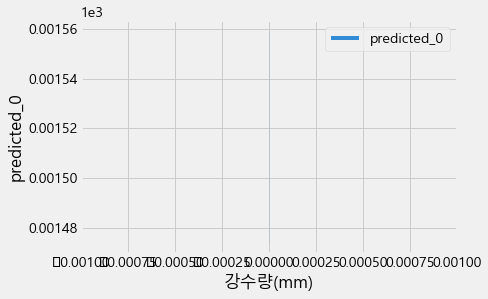

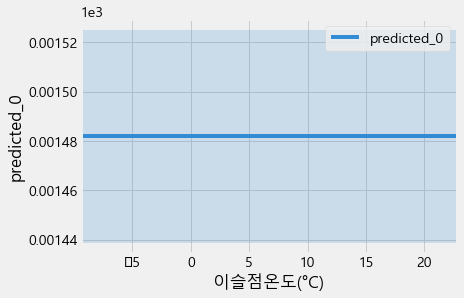

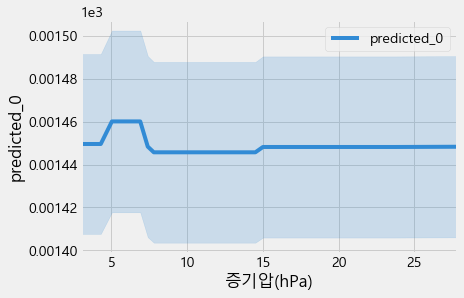

In [21]:
# PDP of low-ranking features
pdp_features = ['강수량(mm)',  '이슬점온도(°C)', '증기압(hPa)']
interpreter.partial_dependence.plot_partial_dependence(pdp_features, im_model, grid_resolution=50, grid_range=(0,1), n_samples=2000, with_variance=True, figsize = (6, 4)) 

## Interpretation with ELI5

In [22]:
# feature importance by gain 
eli5.show_weights(xgr_init)

Weight,Feature
0.7180,일사(MJ/m2)
0.1321,일조(hr)
0.0243,지면온도(°C)
0.0222,습도(%)
0.0181,시간
0.0125,기온(°C)
0.0099,20cm 지중온도(°C)
0.0093,중하층운량(10분위)
0.0072,현지기압(hPa)
0.0072,30cm 지중온도(°C)


In [23]:
# local interpretation by ELI5
doc_num = 94
print('Actual Label:', y_test.iloc[doc_num])
print('Predicted Label:', init_pred[doc_num])
error = nmae(y_true= y_test.iloc[doc_num], y_pred=init_pred[doc_num])  
print('nmae :',error)
eli5.show_prediction(xgr_init.get_booster(), x_test.iloc[doc_num], 
                     feature_names=list(x_test.columns),
                     show_feature_values=True)

Actual Label: 5.337983
Predicted Label: 3.8919642
nmae : 0.1959109609593804


## Interpretation with SHAP

In [24]:
# shapley values of features on test set
explainer = shap.TreeExplainer(xgr_init)
shap_values = explainer.shap_values(x_test)
print('Expected Value:', explainer.expected_value)
print('mean target value of train set :', np.mean(y_train))
pd.DataFrame(shap_values).head()

Expected Value: 1.046236
mean target value of train set : 1.0462681759570673


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.005611,-0.000788,-0.002076,0.007938,0.002915,-0.000324,0.003034,0.003035,-0.125229,-0.738245,0.00326,0.001483,-0.191580,0.000729,0.003946,0.004813,0.015954,-0.005301,-0.045100,-0.00099
1,0.005611,-0.000788,-0.002309,0.007938,0.002915,-0.000324,0.003034,0.003031,-0.125387,-0.736843,0.00326,0.001483,-0.191580,0.000729,0.004183,0.004813,0.015954,-0.006545,-0.045100,-0.00099
2,0.005611,-0.000788,-0.002936,0.008074,0.002915,-0.000324,0.003034,0.003023,-0.125229,-0.737996,0.00326,0.001483,-0.191580,0.000729,0.004183,0.004813,0.016203,-0.005301,-0.045100,-0.00099
3,0.005611,-0.000788,-0.002936,0.008074,0.002915,-0.000324,0.003034,0.003023,-0.125387,-0.736593,0.00326,0.001483,-0.191580,0.000729,0.004183,0.004813,0.016203,-0.006545,-0.045100,-0.00099
4,0.005802,-0.000788,-0.002936,-0.001333,0.002915,-0.000324,0.003034,0.003023,-0.124187,-0.725579,0.00326,0.001483,-0.194237,0.000729,0.004183,0.004813,0.016203,-0.006545,-0.045441,-0.00099


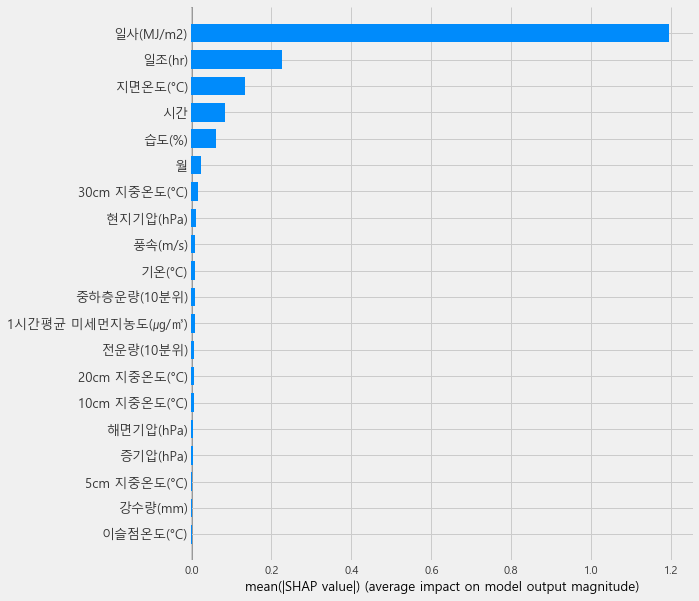

In [25]:
# feature importance plot by shapley values
shap.summary_plot(shap_values, x_test, plot_type="bar")

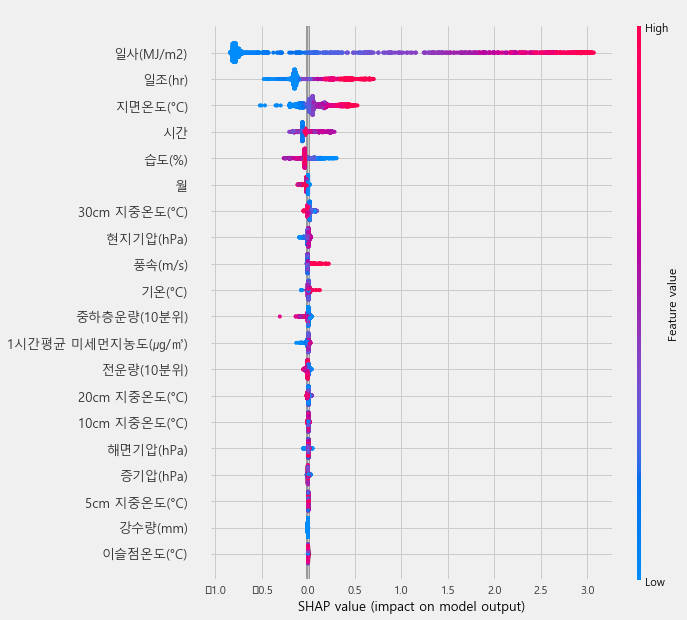

In [26]:
shap.summary_plot(shap_values, x_test)

In [27]:
# local interpretation of 1 April 2019, 10:00 am
doc_num = 10
print('Actual Label:', y_test.iloc[doc_num])
print('Predicted Label:', init_pred[doc_num])
shap.force_plot(explainer.expected_value, shap_values[doc_num,:], x_test.iloc[doc_num,:])

Actual Label: 4.159811
Predicted Label: 4.450216


In [28]:
shap.force_plot(explainer.expected_value, shap_values[:100,:], x_test.iloc[:100,:])

In [29]:
shap.force_plot(explainer.expected_value, shap_values[:100,:], x_test.iloc[:200,:])

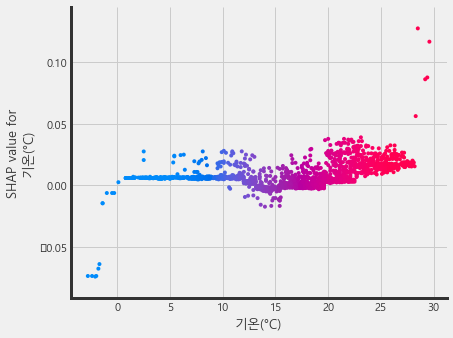

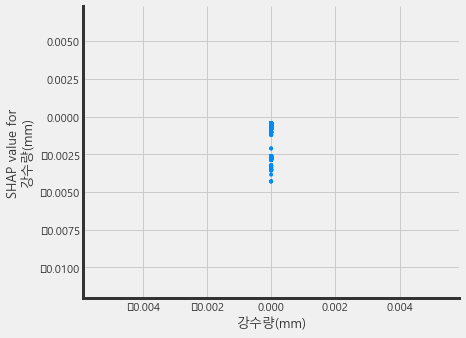

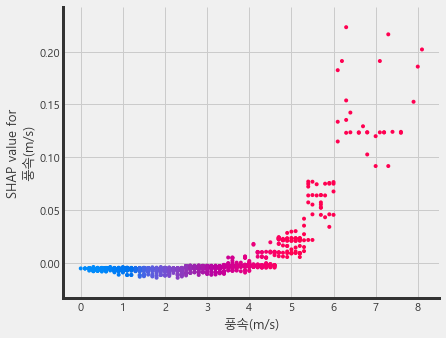

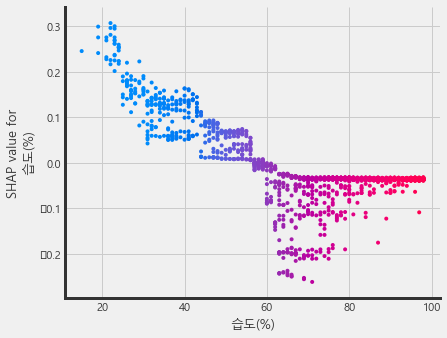

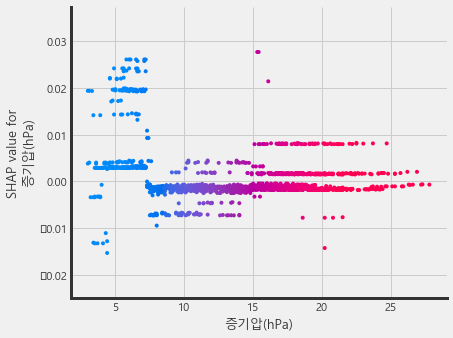

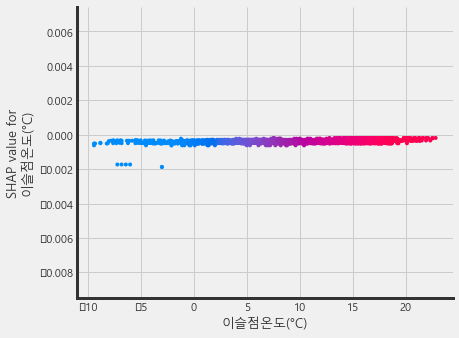

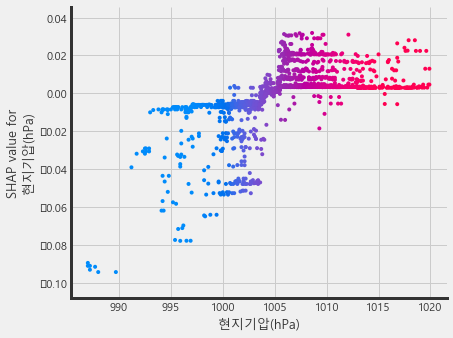

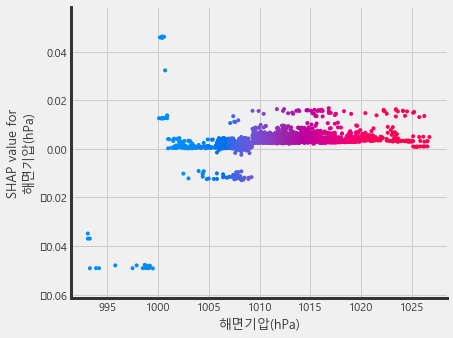

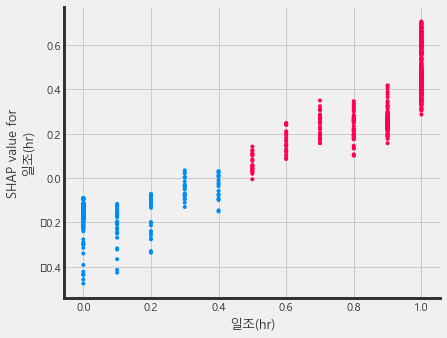

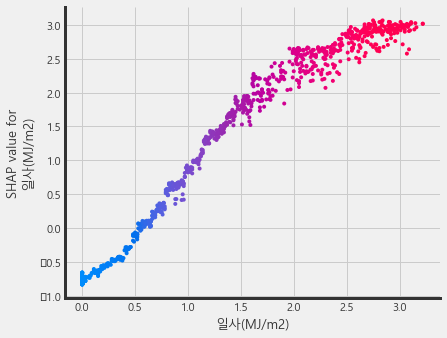

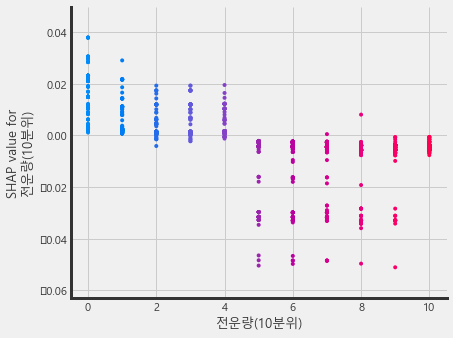

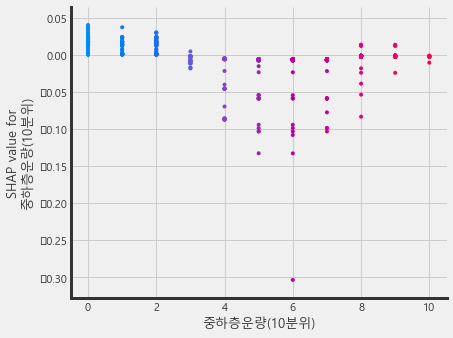

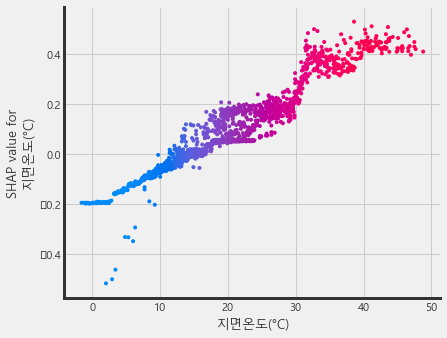

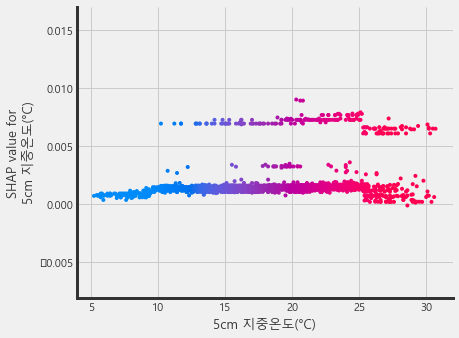

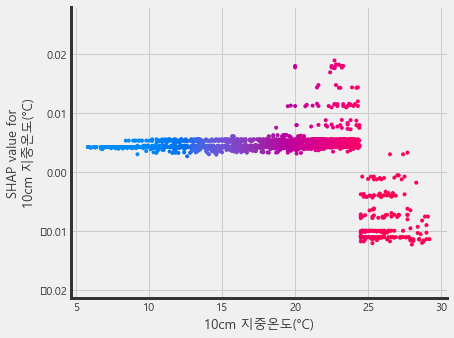

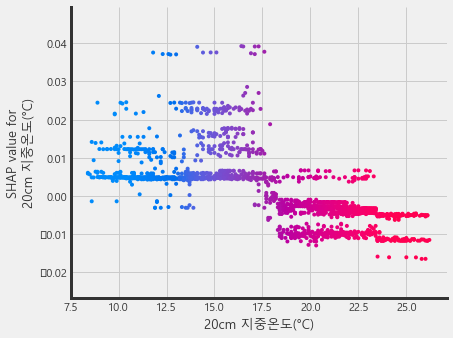

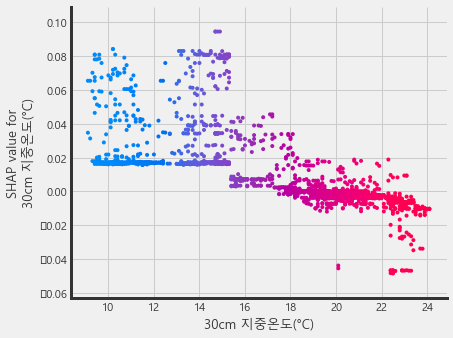

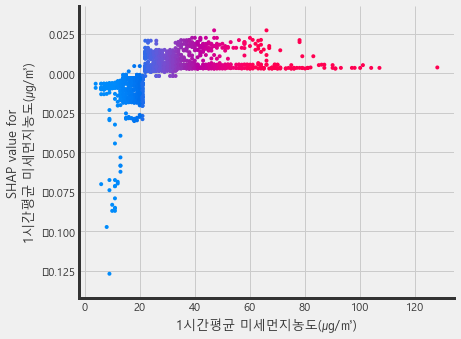

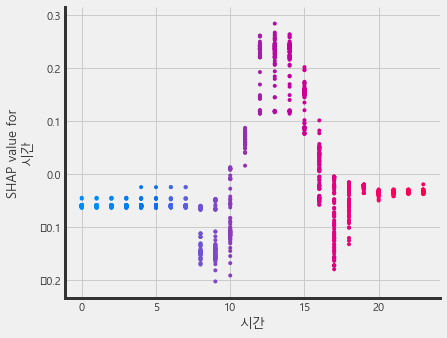

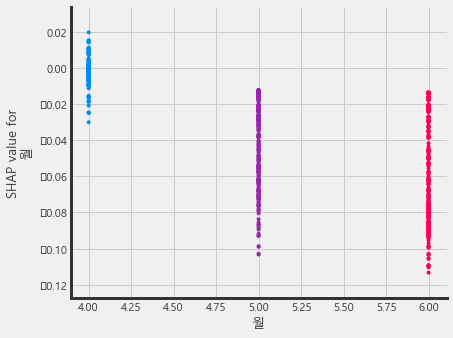

In [30]:
# PDP of all features
for f in x_test.columns :
    shap.dependence_plot(ind=f, interaction_index=f,
                     shap_values=shap_values, 
                     features=x_test,  
                     display_features=x_test)

## Feature Selection by importance plot

In [31]:
# final model training after hyperparameter tuning by grid search
x_train_final = x_train[[ '일조(hr)', '일사(MJ/m2)', '지면온도(°C)', '시간']]
x_test_final = x_test[['일조(hr)', '일사(MJ/m2)', '지면온도(°C)', '시간']]

xgr_final = xgb.XGBRegressor(n_estimators=200, max_depth= 4, min_child_weight=8, subsample=0.7)
xgr_final.fit(x_train_final, y_train,
        eval_set=[(x_train_final, y_train), (x_test_final, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=8, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7)

In [32]:
final_pred = xgr_final.predict(x_test_final)
print('nMAE:',nmae(y_true=y_test,
                   y_pred=final_pred))

nMAE: 0.03051601532708116


In [33]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

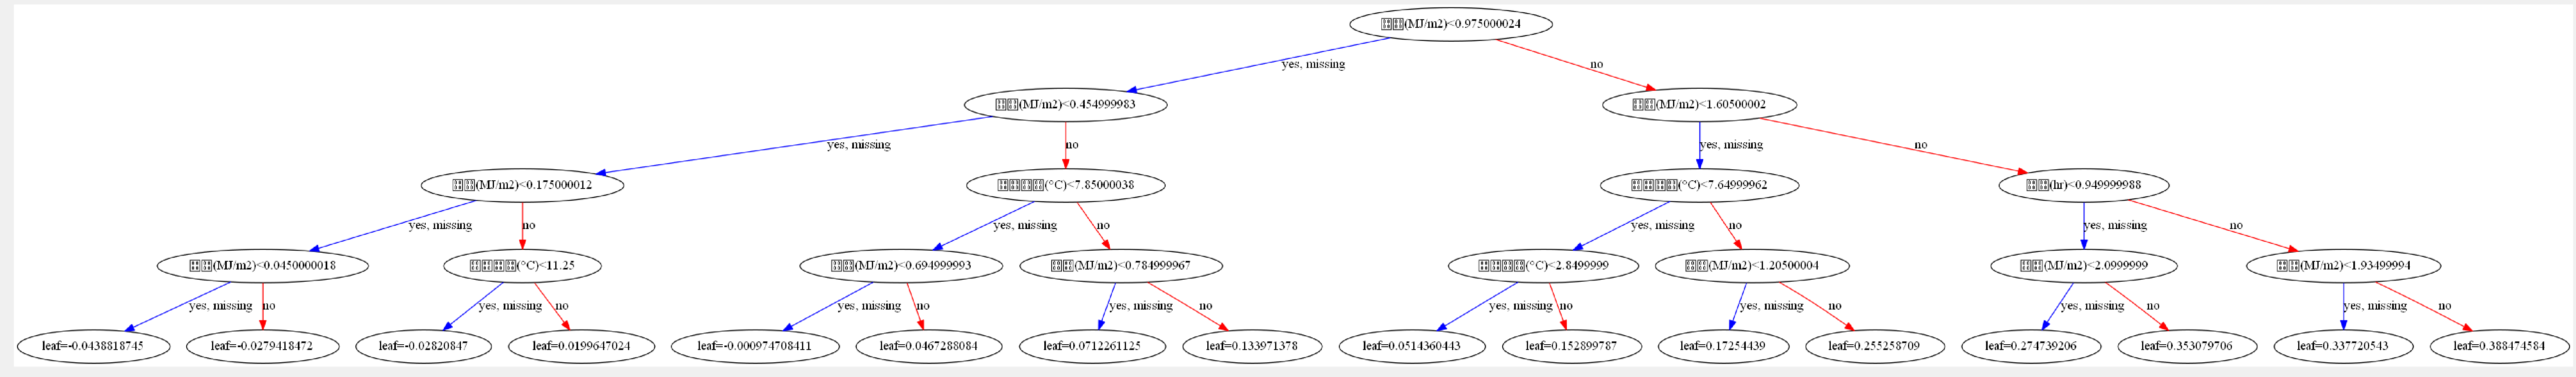

In [34]:
# visualization of tree
fig, ax = plt.subplots(figsize=(100, 80))
plot_tree(xgr_final, ax=ax, num_trees = 1)

In [35]:
# model training without important features
x_train_bad = x_train.drop(['일조(hr)', '일사(MJ/m2)', '지면온도(°C)', '시간'], axis=1) 
x_test_bad = x_test.drop(['일조(hr)', '일사(MJ/m2)', '지면온도(°C)', '시간'], axis=1)

xgr_bad = xgb.XGBRegressor()
xgr_bad.fit(x_train_bad, y_train,
        eval_set=[(x_train_bad, y_train), (x_test_bad, y_test)],
        early_stopping_rounds=50,
       verbose=False)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [37]:
bad_pred = xgr_bad.predict(x_test_bad)
print('nMAE:',nmae(y_true=y_test, y_pred=bad_pred))             

nMAE: 0.09259537857079121


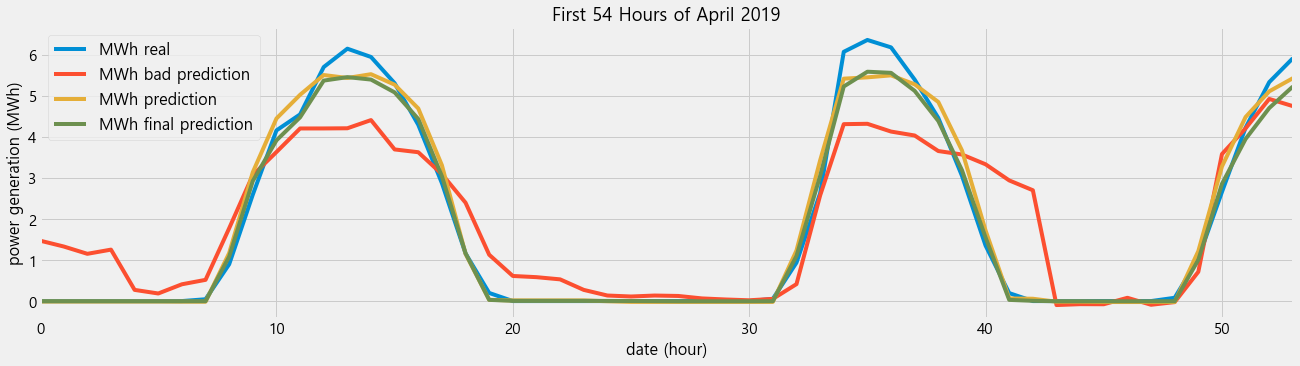

In [38]:
# comparing results
a = pd.DataFrame()
a['MWh real'] = y_test
a['MWh bad prediction'] = bad_pred
a['MWh prediction'] = init_pred
a['MWh final prediction'] = final_pred
b = a.reset_index(drop=True)
c = b[:54]

gen = c.plot(figsize=(20, 5))
gen.set_title("First 54 Hours of April 2019", fontsize = 18)
plt.legend(fontsize=16)
plt.ylabel('power generation (MWh)', fontsize = 16)
plt.xlabel('date (hour)', fontsize = 16)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
f = gen.get_figure()